Load Model:  /Users/flo/Proj/sat_hedge_detection/src/net/models/inception_v3_new_dataset_tuning.tflite
Start classification of biotop:  564140180
Biotop:  564140180  percent:  47.27  nWindows 55


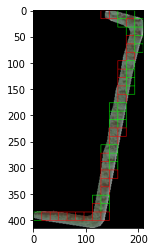

In [6]:
import cv2
import numpy as np
import imutils
from matplotlib import pyplot as plt


# from __future__ import absolute_import
# from __future__ import division
# from __future__ import print_function
import csv

import numpy as np
from PIL import Image
import tensorflow as tf  # TF2

def pyramid(image, scale=1.5, minSize=(20, 20)):
    # yield the original image
    yield image
    # keep looping over the pyramid
    while True:
        # compute the new dimensions of the image and resize it
        w = int(image.shape[1] / scale)
        if w==0:
            w=1
            print("Excepten w:0->1")
            break
        image = imutils.resize(image, width=w)
        # if the resized image does not meet the supplied minimum
        # size, then stop constructing the pyramid
        if image.shape[0] < minSize[1] or image.shape[1] < minSize[0]:
            break
        # yield the next image in the pyramid
        yield image


def sliding_window(image, stepSize, windowSize):
    # slide a window across the image
    for y in range(0, image.shape[0], stepSize):
        for x in range(0, image.shape[1], stepSize):
            # yield the current window
            yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])

def classify_patch(image):
##################################################################
## image_classified, percent, nWindows = classify_patch(image)
## Input: -image (cv2.IMREAD_UNCHANGED format)
## Out:   -image_classified (cv2 image with labeled patches)
##        -percent (Percentage of positive biotop regions dedected)
##        -nWindows (Numburs of patches/sliding windows)
##################################################################

    (winW, winH) = (16, 16)
    c_bio = c_nbio = 0
    for resized in pyramid(image, scale=1000):
        # loop over the sliding window for each layer of the pyramid
        for (x, y, window) in sliding_window(resized, stepSize=winW, windowSize=(winW, winH)):
            mod_im = resized
            # if the window does not meet our desired window size, ignore it
            if window.shape[0] != winH or window.shape[1] != winW:
                continue

            # Disregard windows outside of biotop/border cases
            threshold_black = 100
            gray_version = cv2.cvtColor(window, cv2.COLOR_BGR2GRAY)
            if (cv2.countNonZero(gray_version) > threshold_black):

                img = Image.fromarray(window).convert('RGB')
                img = img.resize([width, height])

                #START CLASSIFICATION PROCESS
                # add N dim
                input_data = np.expand_dims(img, axis=0)
                if floating_model:
                    input_data = (np.float32(input_data) - input_mean) / input_std

                interpreter.set_tensor(input_details[0]['index'], input_data)
                interpreter.invoke()

                output_data = interpreter.get_tensor(output_details[0]['index'])
                results = np.squeeze(output_data)
                top_k = results.argsort()[-5:][::-1]


                if top_k[0] == 1:
                    #no bio
                    c_nbio = c_nbio+1
                    mod_im = cv2.rectangle(mod_im, (x, y), (x + winW, y + winH), (255, 0, 0), 1)
                if top_k[0] == 0:
                    #bio
                    c_bio = c_bio+1
                    mod_im = cv2.rectangle(mod_im, (x, y), (x + winW, y + winH), (0, 255, 0), 1)

        percent = (c_bio*100)/(c_bio+c_nbio)
        image_classified = cv2.cvtColor(mod_im, cv2.COLOR_RGBA2RGB)
        return image_classified, round(percent,2), c_bio+c_nbio



if __name__ == "__main__":
    input_image = '/Users/flo/Proj/sat_hedge_detection/Examples/images/C_2_564140180.png'
    model_file = '/Users/flo/Proj/sat_hedge_detection/src/net/models/inception_v3_new_dataset_tuning.tflite'
    label_file = '/Users/flo/Proj/sat_hedge_detection/src/net/models/labels.txt'
    input_mean = 0
    input_std = 255
    num_threads = None
    show_result = True


    print("Load Model: ", model_file)
    interpreter = tf.lite.Interpreter(
        model_path=model_file, num_threads=num_threads)
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    # check the type of the input tensor
    floating_model = input_details[0]['dtype'] == np.float32

    # NxHxWxC, H:1, W:2
    height = input_details[0]['shape'][1]
    width = input_details[0]['shape'][2]

    image = cv2.imread(input_image, cv2.IMREAD_UNCHANGED)
    biotop_name = input_image[-13:-4]

    print("Start classification of biotop: ",biotop_name)
    image_classified, percent, nWindows = classify_patch(image)

    if show_result:
        print("Biotop: ",biotop_name, " percent: ", percent, " nWindows", nWindows)
        #cv2.imshow("classified image", image_classified)
        #image = cv2.imread("input_path")

        #Show the image with matplotlib
        plt.imshow(image_classified)
        plt.show()